In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import scipy.stats as st

In [6]:
home_value_df = pd.DataFrame(pd.read_csv("Resources/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"))
rental_value_df = pd.DataFrame(pd.read_csv("Resources/Metro_ZORI_AllHomesPlusMultifamily_Smoothed.csv"))
sales_count_df = pd.DataFrame(pd.read_csv("Resources/Metro_sales_count_now_uc_sfrcondo_month.csv"))

In [7]:
# get city average house value
home_value_df_insales_count= home_value_df[home_value_df['RegionName'].isin(sales_count_df['RegionName'])]
home_value_df_city = home_value_df_insales_count.set_index('RegionName')
home_value_df_city = home_value_df_city.fillna(method='backfill')
home_value_df_city_test = home_value_df_city.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName'], axis=1).T
home_value_df_city_test['Year'] = home_value_df_city_test.index

In [8]:
# get state average house value
home_value_df_state = home_value_df_insales_count.drop(['RegionID', 'SizeRank', 'RegionType', 'RegionName'], axis=1)
home_value_df_state['StateName'] = home_value_df_state['StateName'].fillna('US')
home_value_df_state = home_value_df_state.fillna(method='backfill')
home_value_df_state = home_value_df_state.groupby(['StateName'])
home_value_df_state_test = round(home_value_df_state.mean(), 2).T
home_value_df_state_test['Year'] = home_value_df_state_test.index

In [9]:
# get city sales count data
sales_count_df_reindex = sales_count_df.set_index('RegionName')
sales_count_df_city_reindex = sales_count_df_reindex.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName'], axis=1).T
sales_count_df_city_final = sales_count_df_city_reindex.fillna(method='ffill')
sales_count_df_city_final['Year'] = sales_count_df_city_final.index

In [10]:
# get state average house value
sales_count_df_state = sales_count_df.drop(['RegionID', 'SizeRank', 'RegionType', 'RegionName'], axis=1)
sales_count_df_state['StateName'] = sales_count_df_state['StateName'].fillna('US')
sales_count_df_state = sales_count_df_state.groupby(['StateName'])
sales_count_df_state_final = round(sales_count_df_state.mean(), 2)
sales_count_df_state_final = (sales_count_df_state_final.fillna(method='ffill')).T
sales_count_df_state_final['Year'] = sales_count_df_city_final.index

In [11]:
# keep only the cities that is in both data
home_value_df_city_final = home_value_df_city_test[home_value_df_city_test['Year'].isin(sales_count_df_city_final['Year'])]
home_value_df_state_final = home_value_df_state_test[home_value_df_state_test['Year'].isin(sales_count_df_state_final['Year'])]

In [28]:
def house_cor(i):
    # plotting city graph
    plt.figure(figsize=(22, 15))
    fig, ax1 = plt.subplots()
    price_slope, price_int, price_r, p, std_err = st.linregress(np.arange(0, len(home_value_df_city_final['Year'])), home_value_df_city_final[i])
    regress_value = np.arange(0, len(home_value_df_city_final['Year'])) * price_slope + price_int
    ax1.set_xlabel('Time')
    ax1.set_ylabel('House Price', color='blue')
    ax1.bar(home_value_df_city_final[i].index, home_value_df_city_final[i], color='skyblue')
    ax1.plot(np.arange(0, len(home_value_df_city_final['Year'])), regress_value, color='blue')
    ax1.set_xticks(np.arange(0, len(home_value_df_city_final['Year']), 12))

    ax2 = ax1.twinx()
    sales_slope, sales_int, sales_r, p, std_err = st.linregress(np.arange(0, len(home_value_df_city_final['Year'])), sales_count_df_city_final[i])
    sales_regress_value = np.arange(0, len(home_value_df_city_final['Year'])) * sales_slope + sales_int
    ax2.set_ylabel('Number of Sales', color='red')
    ax2.plot(sales_count_df_city_final[i].index, sales_count_df_city_final[i], color='red')
    ax2.plot(np.arange(0, len(home_value_df_city_final['Year'])), sales_regress_value, color='red')
    ax2.set_xticks(np.arange(0, len(home_value_df_city_final['Year']), 12))

    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)
    plt.title(f'{i}')
    
    fig.tight_layout()
    plt.show()

    #calculate value of pearson value of cities
    city_corr_value = st.pearsonr(home_value_df_city_final[i], sales_count_df_city_final[i])
    city_correlation = round(city_corr_value[0], 2)
    if -0.1 < city_correlation < 0.1:
        print(f'The relation between {i} house value and {i} sales count only has a correlation coefficient of {city_correlation} which means there is close to no relationship between the two variables.')
    elif -0.4 < city_correlation < -0.1 or 0.1 < city_correlation < 0.4:
        print(f'The relation between {i} house value and {i} sales count has a correlation coefficient of {city_correlation} which means there is weak relationship between the two variables.')
    elif -0.7 < city_correlation < -0.4 or 0.4 < city_correlation < 0.7:
        print(f'The relation between {i} house value and {i} sales count has a correlation coefficient of {city_correlation} which means there is moderate relationship between the two variables.')
    elif -1.0 < city_correlation < -0.7 or 0.7 < city_correlation < 1.0:
        print(f'The relation between {i} house value and {i} sales count has a correlation coefficient of {city_correlation} which means there is strong relationship between the two variables.')
    
    # plotting state graph
    state = (i.split(', ')[-1])
    fig, ax1 = plt.subplots()
    price_slope, price_int, price_r, p, std_err = st.linregress(np.arange(0, len(home_value_df_state_final['Year'])), home_value_df_state_final[state])
    regress_value = np.arange(0, len(home_value_df_state_final['Year'])) * price_slope + price_int
    ax1.set_xlabel('Time')
    ax1.set_ylabel('House Price', color='blue')
    ax1.bar(home_value_df_state_final[state].index, home_value_df_state_final[state], color='skyblue')
    ax1.plot(np.arange(0, len(home_value_df_state_final['Year'])), regress_value, color='blue')
    ax1.set_xticks(np.arange(0, len(home_value_df_state_final['Year']), 12))

    ax2 = ax1.twinx()
    sales_slope, sales_int, sales_r, p, std_err = st.linregress(np.arange(0, len(home_value_df_state_final['Year'])), sales_count_df_state_final[state])
    sales_regress_value = np.arange(0, len(home_value_df_state_final['Year'])) * sales_slope + sales_int
    ax2.set_ylabel('Number of Sales', color='red')
    ax2.plot(sales_count_df_state_final[state].index, sales_count_df_state_final[state], color='red')
    ax2.plot(np.arange(0, len(home_value_df_state_final['Year'])), sales_regress_value, color='red')
    ax2.set_xticks(np.arange(0, len(home_value_df_city_final['Year']), 12))

    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)
    plt.title(f'{state}')
    
    fig.tight_layout()
    plt.show()

    #calculate value of pearson value
    state_corr_value = st.pearsonr(home_value_df_state_final[state], sales_count_df_state_final[state])
    state_correlation = round(state_corr_value[0], 2)
    if -0.1 < state_correlation < 0.1:
        print(f'The relation between {state} house value and {state} sales count only has a correlation coefficient of {state_correlation} which means there is close to no relationship between the two variables.')
    elif -0.4 < state_correlation < -0.1 or 0.1 < state_correlation < 0.4:
        print(f'The relation between {state} house value and {state} sales count has a correlation coefficient of {state_correlation} which means there is weak relationship between the two variables.')
    elif -0.7 < state_correlation < -0.4 or 0.4 < state_correlation < 0.7:
        print(f'The relation between {state} house value and {state} sales count has a correlation coefficient of {state_correlation} which means there is moderate relationship between the two variables.')
    elif -1.0 < state_correlation < -0.7 or 0.7 < state_correlation < 1.0:
        print(f'The relation between {state} house value and {state} sales count has a correlation coefficient of {state_correlation} which means there is strong relationship between the two variables.')

In [13]:
state = input('What state would you like to search for?')
while (home_value_df_city[home_value_df_city['StateName'] == state].values) is False:
        state = input('Try another state')
else:
    print(list(home_value_df_city[home_value_df_city['StateName'] == state].index))

['Los Angeles-Long Beach-Anaheim, CA', 'San Francisco, CA', 'Riverside, CA', 'San Diego, CA', 'Sacramento, CA', 'San Jose, CA', 'Fresno, CA', 'Bakersfield, CA', 'Ventura, CA', 'Stockton, CA']


<Figure size 1584x1080 with 0 Axes>

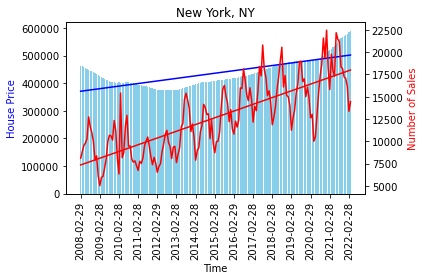

The relation between New York, NY house value and New York, NY sales count has a correlation coefficient of 0.66 which means there is moderate relationship between the two variables.


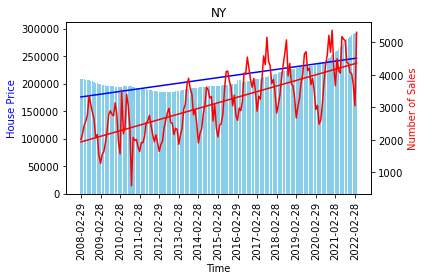

The relation between NY house value and NY sales count has a correlation coefficient of 0.64 which means there is moderate relationship between the two variables.


In [30]:
house_cor('New York, NY')